#### Index
1. Importing Libraries
2. Data and it's preprocessing
3. Model
4. Model's 50 lowest confidence predictions
5. CarliniL2Method For Correct Prediction of Model
6. Creating Adversarial Dataset
7. Defense

### Importing Libraries

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
from art.estimators.classification import TensorFlowV2Classifier, KerasClassifier
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
import pandas as pd
import pickle
import os
from tensorflow.keras.callbacks import ModelCheckpoint

c:\Users\dangw\anaconda3\envs\mnist\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dangw\anaconda3\envs\mnist\lib\site-packages\art\estimators\certification\__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


### Data and it's preprocessing

In [ ]:
# Initialize empty lists to hold all data and labels
all_data = []
all_labels = []

def file_open(file_path):
    try:
        with open(file_path, 'rb') as f:
            data_dict = pickle.load(f, encoding='latin1')
            all_data.append(data_dict['data'])  # Append batch data
            all_labels.extend(data_dict['labels'])  # Extend labels
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

# Load all batches
base_path = r'..\..\2. CIFER-10\Dataset\cifar-10-batches-py'
for i in range(1, 6):
    file_path = os.path.join(base_path, f"data_batch_{i}")
    file_open(file_path)

# Convert the list of arrays into a single numpy array
all_data = np.vstack(all_data)  
all_labels = np.array(all_labels) 

print(f"Data shape: {all_data.shape}")  
print(f"Labels shape: {all_labels.shape}")  


Data shape: (50000, 3072)
Labels shape: (50000,)


In [3]:
img_3d = all_data[0].reshape((3, 32, 32))
img = img_3d.transpose(1, 2, 0)

In [4]:
data = pd.DataFrame({
    'image_data': list(all_data),  # Each row will contain 3072 values for image data
    'label': all_labels  # Fine-grained labels
})

In [5]:
data['image_data'] = data['image_data'].apply(
    lambda x: np.array(x).reshape((3, 32, 32)).transpose(1, 2, 0)
)

In [6]:
data['image_data'] = data['image_data'] / 255.0

In [7]:
data['image_data'] = data['image_data'].map(lambda x: (np.round(x, 2)))

In [ ]:
import pickle

# Path to the CIFAR-100 train file
file_path = r'..\..\2. CIFER-10\Dataset\cifar-10-batches-py\test_batch'

# Load the data using pickle with the correct encoding
with open(file_path, 'rb') as f:
    test_dict = pickle.load(f, encoding='latin1')

# The data_dict will contain the images and their corresponding labels
print(test_dict.keys()) 

dict_keys(['batch_label', 'labels', 'data', 'filenames'])


In [9]:
test = pd.DataFrame({
    'image_data': list(test_dict['data']),  # Each row will contain 3072 values for image data
    'label': test_dict['labels']  # Fine-grained labels
})

In [10]:
test['image_data'] = test['image_data'].apply(
    lambda x: np.array(x).reshape((3, 32, 32)).transpose(1, 2, 0)
)

In [11]:
test['image_data'] = test['image_data'] / 255.0

In [12]:
test['image_data'] = test['image_data'].map(lambda x: (np.round(x, 2)))

In [ ]:
train_images = np.array(data['image_data'].tolist())  # Convert list of 3D arrays to numpy array
train_labels = np.array(data['label'])  

In [15]:
test_image = np.array(test['image_data'].tolist())  # Convert list of 3D arrays to numpy array
test_label = np.array(test['label'])  

### Model

In [16]:
model = tf.keras.models.load_model(r"..\..\2. CIFER-10\\VGG.h5")

In [17]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0000001),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [18]:
training = model.fit(train_images, train_labels, epochs=1)

1563/1563 [==============================] - 15s 8ms/step - loss: 0.0544 - sparse_categorical_accuracy: 0.9818


In [19]:
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)

In [22]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define loss function
loss_object = SparseCategoricalCrossentropy()

In [23]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), clip_values=(0, 1), loss_object=loss_object, channels_first=False)

In [24]:
from art.attacks.evasion import CarliniL2Method

In [25]:
test_images = test_images.numpy() if isinstance(test_images, tf.Tensor) else test_images

In [ ]:
num_samples = test_images.shape[0]

# Select 500 random indices without replacement
random_indices = np.random.choice(num_samples, 500, replace=False)

# Select corresponding images
selected_images = test_images[random_indices]


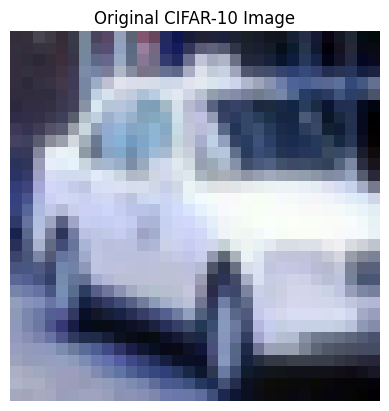

In [ ]:
plt.imshow(selected_images[1])
plt.title("Original CIFAR-10 Image")
plt.axis("off") 
plt.show()

### Model's 50 lowest confidence prediction

In [36]:
predictions = model.predict(test_images)

In [37]:
confidence_score = np.max(predictions, axis=1)

In [38]:
least_confidence_indices = np.argsort(confidence_score)[:10]

In [39]:
least_confidence_images = test_images[least_confidence_indices]
least_confidence_labels = test_label[least_confidence_indices]

In [ ]:
attack_cw_4 = CarliniL2Method(
    classifier=classifier,
    learning_rate=0.01, 
    initial_const=0.01, 
)

In [ ]:
x_test_adv_4 = attack_cw_4.generate(least_confidence_images[3:4])

C&W L_2: 100%|██████████| 1/1 [01:24<00:00, 84.69s/it]


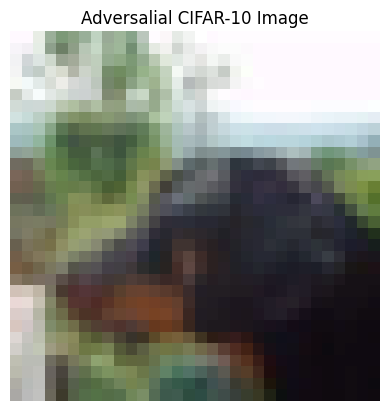

In [ ]:
plt.imshow(test_images[least_confidence_indices[0]]) 
plt.title("Adversalial CIFAR-10 Image")
plt.axis("off")
plt.show()

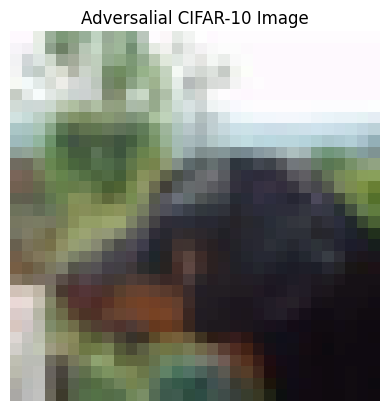

In [ ]:
plt.imshow(x_test_adv_4[0]) 
plt.title("Adversalial CIFAR-10 Image")
plt.axis("off")
plt.show()

In [ ]:
perturbation = np.mean(np.abs(x_test_adv_4 - least_confidence_images))
print(f"Average perturbation: {perturbation:.10f}")

Average perturbation: 0.0000148492


In [ ]:
original_preds = np.argmax(model.predict(least_confidence_images), axis=1)
adv_preds = np.argmax(model.predict(x_test_adv_4), axis=1)


for i in range(1):
    print(f"Image {i}:")
    print(f"Original Label: {least_confidence_labels[i]}, "
          f"Original Pred: {original_preds[i]}, "
          f"Adversarial Pred: {adv_preds[i]}")

Image 0:
Original Label: 5, Original Pred: 9, Adversarial Pred: 3


### CarliniL2Method For Correct Prediction of Model

In [76]:
least_confidence_indices = np.argsort(confidence_score)[:50]
least_confidence_images = test_images[least_confidence_indices]
least_confidence_labels = test_label[least_confidence_indices]

In [ ]:
original_preds = np.argmax(model.predict(least_confidence_images), axis=1)

for i in range(50):
    print(f"Image {i}:")
    print(f"Original Label: {least_confidence_labels[i]}, "
          f"Original Pred: {original_preds[i]}, ")

Image 0:
Original Label: 5, Original Pred: 9, 
Image 1:
Original Label: 4, Original Pred: 2, 
Image 2:
Original Label: 8, Original Pred: 6, 
Image 3:
Original Label: 2, Original Pred: 5, 
Image 4:
Original Label: 2, Original Pred: 2, 
Image 5:
Original Label: 5, Original Pred: 2, 
Image 6:
Original Label: 3, Original Pred: 9, 
Image 7:
Original Label: 8, Original Pred: 3, 
Image 8:
Original Label: 1, Original Pred: 9, 
Image 9:
Original Label: 2, Original Pred: 4, 
Image 10:
Original Label: 3, Original Pred: 7, 
Image 11:
Original Label: 3, Original Pred: 4, 
Image 12:
Original Label: 2, Original Pred: 3, 
Image 13:
Original Label: 2, Original Pred: 6, 
Image 14:
Original Label: 9, Original Pred: 3, 
Image 15:
Original Label: 4, Original Pred: 6, 
Image 16:
Original Label: 5, Original Pred: 5, 
Image 17:
Original Label: 5, Original Pred: 2, 
Image 18:
Original Label: 6, Original Pred: 6, 
Image 19:
Original Label: 1, Original Pred: 3, 
Image 20:
Original Label: 7, Original Pred: 3, 
Im

In [78]:
least_confidence_images[4].shape

(32, 32, 3)

In [48]:
original_image = np.expand_dims(least_confidence_images[4], axis=0)

In [49]:
adv_img = attack_cw_4.generate(original_image)

C&W L_2: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


In [50]:
adv_pred = np.argmax(classifier.predict(adv_img))

(-0.5, 31.5, 31.5, -0.5)

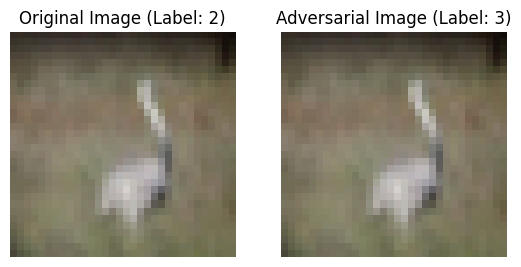

In [53]:
plt.subplot(1, 2, 1)
plt.imshow(least_confidence_images[4])
plt.title(f"Original Image (Label: {least_confidence_labels[4]})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adv_img[0])
plt.title(f"Adversarial Image (Label: {adv_pred})")
plt.axis("off")

In [57]:
perturbation = np.mean(np.abs(least_confidence_images[4] - adv_img[0]))
print(f"Average perturbation: {perturbation:.10f}")

Average perturbation: 0.0000142759


### Creating Adversarial Dataset

In [79]:
adversarial_image = least_confidence_images

In [80]:
adversarial_image.shape

(50, 32, 32, 3)

In [81]:
adv_data = attack_cw_4.generate(adversarial_image)

C&W L_2: 100%|██████████| 50/50 [03:10<00:00,  3.82s/it]


### Defense

In [28]:
from art.defences.preprocessor import FeatureSqueezing

In [29]:
fs = FeatureSqueezing(bit_depth=8, clip_values=(0, 1))

In [30]:
x_test_defended, _ = fs(test_image)

In [33]:
accuracy_before = np.mean(np.argmax(classifier.predict(test_image), axis=1) == test_label)
print("Accuracy before feature Squeezing: ", accuracy_before)

Accuracy before feature Squeezing:  0.806


In [34]:
accuracy_after = np.mean(np.argmax(classifier.predict(x_test_defended), axis=1) == test_label)
print("Accuracy after feature Squeezing: ", accuracy_after)

Accuracy after feature Squeezing:  0.8055


In [82]:
x_adv_defended, _ = fs(adv_data)

Model Accuracy on model's lowest 50 confidence predictions

In [83]:
original_acc = np.mean(np.argmax(classifier.predict(least_confidence_images), axis=1) == least_confidence_labels)
print("Accuracy on adversarial data before feature Squeezing: ", original_acc)

Accuracy on adversarial data before feature Squeezing:  0.26


Model Accuracy on adversarial data

In [84]:
acc_adv_before = np.mean(np.argmax(classifier.predict(adv_data), axis=1) == np.argmax(model.predict(adversarial_image), axis=1))
print("Accuracy on adversarial data before feature Squeezing: ", acc_adv_before)

Accuracy on adversarial data before feature Squeezing:  0.04


Model's Accuracy on adversarial data after freature Squeezing

In [85]:
acc_adv_before = np.mean(np.argmax(classifier.predict(x_adv_defended), axis=1) == np.argmax(model.predict(adversarial_image), axis=1))
print("Accuracy on adversarial data After feature Squeezing: ", acc_adv_before)

Accuracy on adversarial data After feature Squeezing:  0.32
